# Merging and Combining data  

Sometimes we need to combine data. In many instances, adding additional data is a way to enrich both the questions that can be asked of your original data set and the answers that can be provided. This notebook looks at ways to  create one dataframe from two or more dataframes.  That's colloquially known as a **merge** or a **join**. There are lots of ways to do this.  We do a couple but supply references to more at the end.  

Along the way we take an extended detour to review methods for **downloading** and **unzipping** compressed files.  The tools we use here have a broad range of other applications, including web scraping.  

Outline:  

* [MovieLens data](#movielens).  A collection of movies and individual ratings.  
* [Automate file download](#requests).  Use the requests package to get a zipped file, then other tools to unzip it and read in the contents.  
* [Merge movie names and ratings](#merge-movies).  Merge information from two dataframes with Pandas' `merge` function.  

**Note: requires internet access to run.**  

In [2]:
import pandas as pd             # data package
import matplotlib.pyplot as plt # graphics 

# these are new 
import requests, io             # internet and input tools  
import zipfile as zf            # zip file tools 
import shutil                   # file management tools 
import os                       # operating system tools (check files)

## A Quick Primer on Merging

First, lets look at some simple examples and see how merging works. Then we will explore this more with the Movie data. 

There are two key commands here. First here is `pd.append`. This operation is useful when we just want to stack, say, two DataFrames on top of each other. For example, in the basketball dataset, we could layer on the 2017 and 2018 data. 

The next important command here is ``pd.merge()`` which is a pandas method applied to two data frames. What you need to provide pandas are the two data frames, the type of merge, and the ``key`` to merge on. Below, I'm going to look at a couple of common examples that I come across, one-to-one merges and many to one merges (in the documentation there is a discussion of many to many merges). Lets see this:

### Append

This operation is fairly straigt foward, lets just stack on ontop of each other. 

In [7]:
gdp_rich_data = {"cntry": ["USA", "JPN"],
               "gdp": [100, 110]}

gdp_poor_data = {"cntry": ["TZA", "SAR"],
               "gdp": [25, 50]}

df_one = pd.DataFrame(gdp_rich_data)
df_two = pd.DataFrame(gdp_poor_data)

df_one.append(df_two, ignore_index = True)


,cntry,gdp
0,USA,100
1,JPN,110
2,TZA,25
3,SAR,50


In [9]:
gdp_rich_data = {"cntry": ["USA", "JPN"],
               "gdp": [100, 110],
                "cpi": [2, 3]}

gdp_poor_data = {"cntry": ["TZA", "SAR"],
               "gdp_f": [25, 50]}

df_one = pd.DataFrame(gdp_rich_data)
df_two = pd.DataFrame(gdp_poor_data)

df_one.append(df_two, ignore_index = True)


,cntry,cpi,gdp,gdp_f
0,USA,2.0,100.0,NaN
1,JPN,3.0,110.0,NaN
2,TZA,NaN,NaN,25.0
3,SAR,NaN,NaN,50.0


In [13]:
gdp_data = {"cntry": ["USA", "JPN"],
               "gdp": [100, 110]}
cpi_data = {"cntry": ["USA", "JPN"],
               "cpi": [10, 15]}

df_one = pd.DataFrame(gdp_data)
df_two = pd.DataFrame(cpi_data)

# Here is a classic one-to-one merge
combo = pd.merge(df_one, df_two,# left df, right df
                 on='cntry',       # link with cntry
                 how='left',        # add to left...does this matter here?
                 indicator=True)  # Tells us what happend

combo.head()

,cntry,gdp,cpi,_merge
0,USA,100,10,both
1,JPN,110,15,both


So we have two data frames, one with gdp data and one with cpi data for two countries in **both** dataframes. We want to create one dataframe out of the two initial ones. So then ``pd.merge`` takes the left data frame, the right dataframe, and then we provide some options. 
- The most important one is ``on`` this provides the key to match up the two dataframes. In this case this is the country.
- The second important on is ``how`` this tells us the method to which the merge is undertaken. There are four options, ``left`` (which just takes the keys from the left), ``right`` (which just takes the keys on the right), ``inner`` (which just takes the intersection of the keys), and ``outer`` (which takes the union). Note here it does not matter because there is an exact one-to-one correspondence of the keys.
- Finally, I like to use the indicator option that will generate a new column with a description of what happened. In this case, the key was found on both.

Below is another example. It is still a one-to-one merge, but now there on some keys on one dataframe that are not in another...

In [11]:
# Here is still a one-to-one merge, but a bit more complicated...
# Since the two dataframes have different stuff missing...

gdp_data = {"cntry": ["USA", "JPN", "BRZ"],
               "gdp": [100, 110, 50]}
cpi_data = {"cntry": ["USA", "JPN", "CHN"],
               "cpi": [10, 15, 8]}

df_one = pd.DataFrame(gdp_data)
df_two = pd.DataFrame(cpi_data)

# Here is a classic one-to-one merge
combo = pd.merge(df_one, df_two,   # left df, right df
                 how='left',      # Try the different options, inner, outer, left, right...what happens.
                 on='cntry',       # link with cntry
                 indicator=True)  # Tells us what happend

combo.head()

,cntry,gdp,cpi,_merge
0,USA,100,10.0,both
1,JPN,110,15.0,both
2,BRZ,50,NaN,left_only


**Try different ``how`` operations ...what happens?** 

Now below is an example of a many-to-one merge. That is we will assign many values to one depending upon the key. This is what is going on with the MovieLens data below...

In [12]:
gdp_data = {"cntry": ["USA", "JPN", "BRZ"],
               "gdp": [100, 110, 50]}
state_pop_data = {"cntry": ["USA", "USA", "JPN", "JPN"],
                  "state": ["NY", "AK", "Kyoto", "Tokyo"],
                  "pop": [10, 5, 8, 4]}

df_one = pd.DataFrame(gdp_data)
df_two = pd.DataFrame(state_pop_data)

# Here is a classic one-to-one merge
combo = pd.merge(df_one, df_two,   # left df, right df
                 how='inner',      # Try the different options, inner, outer, left, right...what happens.
                 on='cntry',       # link with cntry
                 indicator=True)  # Tells us what happend

combo.head()

,cntry,gdp,pop,state,_merge
0,USA,100,10,NY,both
1,USA,100,5,AK,both
2,JPN,110,8,Kyoto,both
3,JPN,110,4,Tokyo,both


Note what is going on here. For each state (or prefecture in Japan)....(the many part) the countries GDP is assigned to the one value associated with the key, in this case GDP. Again, **Try different ``how`` operations ...what happens?** 

Lets see this at work for a lager, more interesting dataset.

## MovieLens data 

The data comes as a zip file that contains several csv's.  We get the details from the README inside.  (It's written in Markdown, so it's easier to read if we use a browser to format it.  Or we could cut and paste into a Markdown cell in an IPython notebook.)  

The file descriptions are:  

* `ratings.csv`:  each line is an individual film rating with the rater and movie id's and the rating.  Order:  `userId, movieId, rating, timestamp`. 
* `tags.csv`:  each line is a tag on a specific film.  Order:  `userId, movieId, tag, timestamp`. 
* `movies.csv`:  each line is a movie name, its id, and its genre.  Order:  `movieId, title, genres`.  Multiple genres are separated by "pipes" `|`.   
* `links.csv`:  each line contains the movie id and corresponding id's at [IMBd](http://www.imdb.com/) and [TMDb](https://www.themoviedb.org/).  

The easy way to input this data is to download the zip file onto our computer, unzip it, and read the individual csv files using `read.csv()`.  But **anyone can do it the easy way**.  We want to automate this, so we can redo it without any manual steps.  This takes some effort, but once we have it down we can apply it to lots of other data sources.  

## Automate file download 

We're looking for an automated way, so that if we do this again, possibly with updated data, the whole process is in our code.  Automated data entry involves these steps: 

* Get the file.  We use the [requests](http://docs.python-requests.org/) package, which handles internet files and comes pre-installed with Anaconda. This kind of thing was hidden behind the scenes in the Pandas `read_csv` function, but here we need to do it for ourselves. The package authors add:  
>Recreational use of other HTTP libraries may result in dangerous side-effects, including: security vulnerabilities, verbose code, reinventing the wheel, constantly reading documentation, depression, headaches, or even death.
* Convert to zip.   Requests simply loads whatever's at the given url. The [io](https://docs.python.org/3.5/library/io.html) module's `io.Bytes` reconstructs it as a file, here a zip file.  
* Unzip the file.  We use the [zipfile](https://docs.python.org/3.5/library/zipfile.html) module, which is part of core Python, to extract the files inside.   
* Read in the csv's.  Now that we've extracted the csv files, we use `read_csv` as usual.  

We found this [Stack Overflow exchange](http://stackoverflow.com/questions/23419322/download-a-zip-file-and-extract-it-in-memory-using-python3) helpful. 

**Digression.**  This is probably more than you want to know, but it's a reminder of what goes on behind the scenes when we apply `read_csv` to a url.  Here we grab whatever is at the url.  Then we get its contents, convert it to bytes, identify it as a zip file, and read its components using `read_csv`.  It's a lot easier when this happens automatically, but a reminder what's involved if we ever have to look into the details.  

In [3]:
# get "response" from url 
url = 'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
r = requests.get(url) 

# describe response 
print('Response status code:', r.status_code)
# Here is a link to what different coes mean: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status
# Quick summary 200 is good, 400 is bad, i.e. its not responsive may not exist. Othere indicate something
# more complicated might be going on.

print('Response type:', type(r))
print('Response .content:', type(r.content)) 
print('Response headers:\n', r.headers, sep='')

Response status code: 200
Response type: <class 'requests.models.Response'>
Response .content: <class 'bytes'>
Response headers:
{'Date': 'Wed, 15 Nov 2017 16:39:34 GMT', 'Server': 'Apache/2.4.18 (Ubuntu)', 'Content-Length': '918269', 'Accept-Ranges': 'bytes', 'ETag': '"e02fd-53f1536837040"', 'Content-Type': 'application/zip', 'Connection': 'Keep-Alive', 'Keep-Alive': 'timeout=5, max=100', 'Last-Modified': 'Mon, 17 Oct 2016 20:13:45 GMT'}


In [4]:
# convert bytes to zip file  
mlz = zf.ZipFile(io.BytesIO(r.content)) 
print('Type of zipfile object:', type(mlz))

Type of zipfile object: <class 'zipfile.ZipFile'>


In [5]:
# what's in the zip file?
# This is really cool...
mlz.namelist()

['ml-latest-small/',
 'ml-latest-small/links.csv',
 'ml-latest-small/movies.csv',
 'ml-latest-small/ratings.csv',
 'ml-latest-small/README.txt',
 'ml-latest-small/tags.csv']

In [6]:
# extract and read csv's
movies  = pd.read_csv(mlz.open(mlz.namelist()[2]))
ratings = pd.read_csv(mlz.open(mlz.namelist()[3]))

In [7]:
# Whip through the dataframes and look what is going on...

for df in [movies, ratings]:
    print('Type:', type(df))
    print('Dimensions:', df.shape)
    print('Variables:', list(df))
    print('First few rows', df.head(3), '\n')

Type: <class 'pandas.core.frame.DataFrame'>
Dimensions: (9125, 3)
Variables: ['movieId', 'title', 'genres']
First few rows    movieId                    title  \
0        1         Toy Story (1995)   
1        2           Jumanji (1995)   
2        3  Grumpier Old Men (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance   

Type: <class 'pandas.core.frame.DataFrame'>
Dimensions: (100004, 4)
Variables: ['userId', 'movieId', 'rating', 'timestamp']
First few rows    userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182 



**Exercise.** Something to do together. Suppose we wanted to save the files on our computer.  How would we do it? Would we prefer individual csv's or a single zip?

## Merging ratings and movie titles 

The movie ratings in the dataframe `ratings` give us individual opinions about movies, but they don't include the name of the movie.   Why not?  Rather than include the name every time a movie is rated, the MovieLens data associates each rating with a movie code, than stores the names of movies associated with each movie code in the dataframe `movies`.  We run across this a lot:  some information is in one data table, other information is in another. Here, since this was an intientional decision to split up the files, there is a natural ``key`` that can be used to link the two. 

Our **want** is therefore to add the movie name to the `ratings` dataframe.  We say we **merge** the two dataferames.  There are lots of ways to merge.  Here we do one as an illustration.  

### Merging

Here's roughly what's involved in what we're doing.  We take the `movieId` variable from `ratings` and look it up in `movies`.  When we find it, we look up the `title` and add it as a column in `ratings`.  The variable `movieId` is common, so we can use it to link the two dataframes.  Is this a many-to-one merge or one-to-one merge?

In [34]:
print('Dimensions of ratings:', ratings.shape)
print('Dimensions of movies:', movies.shape)

# Again note how there are more ratings than movies...
# It is a many-to-one merge, assign the many ratings
# to a ONE movie title. 

combo = pd.merge(ratings, movies,   # left and right df's
                 how='left',        # add to left 
                 on='movieId',       # link with this variable/column 
                 indicator=True) 

print('Dimensions of new df:', combo.shape)

combo.head()



Dimensions of ratings: (100004, 4)
Dimensions of movies: (9125, 3)
Dimensions of new df: (100004, 7)


,userId,movieId,rating,timestamp,title,genres,_merge
0,1,31,2.5,1260759144,Dangerous Minds (1995),Drama,both
1,1,1029,3.0,1260759179,Dumbo (1941),Animation|Children|Drama|Musical,both
2,1,1061,3.0,1260759182,Sleepers (1996),Thriller,both
3,1,1129,2.0,1260759185,Escape from New York (1981),Action|Adventure|Sci-Fi|Thriller,both
4,1,1172,4.0,1260759205,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama,both


**Now try the merge with right part...What is going on here?**

In [ ]:
combo = pd.merge(ratings, movies,   # left and right df's
                 how='right',        # add to left 
                 on='movieId',       # link with this variable/column 
                 indicator=True) 

print('Dimensions of new df:', combo.shape)

combo.head()

combo[combo["_merge"] == "right_only"]

Now we can save this for work later on our local computer

In [15]:
# save as csv file for future use 
#combo.to_csv('mlcombined.csv')

print('Current directory:\n', os.getcwd(), sep='')
print('List of files:', os.listdir(), sep='\n')

Current directory:
C:\data_bootcamp\Data_Bootcamp_Fall_2017\data_bootcamp_1113
List of files:
['.ipynb_checkpoints', 'merge_iozip_data.ipynb', 'mlcombined.csv']


**Exercise.** Some of these we know how to do, the others we don't.  For the ones we know, what is the answer?  For the others, what (in loose terms) do we need to be able to do to come up with an answer?  

* What is the overall average rating?  By genre?
* What is the overall distribution of ratings?  


Average Rating 3.54
Median Rating 4.0


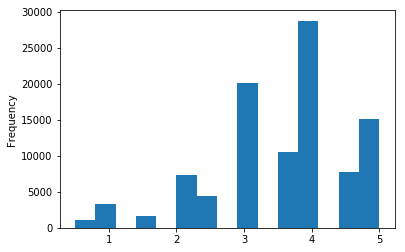

In [46]:
print("Average Rating",round(combo.rating.mean(),2))
print("Median Rating",round(combo.rating.median(),2))

fig, ax = plt.subplots()

combo.rating.plot(ax = ax, kind = "hist", bins = 15)
plt.show()

Lets ask a couple of more questions, this practices `groupby`
* What is the average rating of each movie?  
* How many ratings does each movie get? 

In [69]:
grouped = combo.groupby("title")
# This is similar syntax to that used in the Chiplotle data
# Create the groupby object.

movie_ratings = grouped.rating.agg(["count","mean"])
# Then aggregate the ratings...how? In two ways, we pass a list
# saying, take the count, take the mean.

movie_ratings.head(20)

,count,mean
title,,
"""Great Performances"" Cats (1998)",2,1.750000
$9.99 (2008),3,3.833333
'Hellboy': The Seeds of Creation (2004),1,2.000000
'Neath the Arizona Skies (1934),1,0.500000
'Round Midnight (1986),2,2.250000
'Salem's Lot (2004),1,3.500000
'Til There Was You (1997),4,2.625000
"'burbs, The (1989)",19,3.052632
'night Mother (1986),3,5.000000


In [70]:
# Now lets look at movies, with only at least 20 ratings, and then sort them.
# So what are the best rated movies...

movie_ratings[movie_ratings["count"] >= 20.0]["mean"].sort_values().tail(20)

title
12 Angry Men (1957)                 4.304054
Conversation, The (1974)            4.304348
Rear Window (1954)                  4.315217
Happiness (1998)                    4.326087
Chinatown (1974)                    4.335526
Raging Bull (1980)                  4.350000
Philadelphia Story, The (1940)      4.351351
Modern Times (1936)                 4.359375
Usual Suspects, The (1995)          4.370647
It Happened One Night (1934)        4.380000
Godfather: Part II, The (1974)      4.385185
Band of Brothers (2001)             4.386364
Maltese Falcon, The (1941)          4.387097
Roger & Me (1989)                   4.392857
African Queen, The (1951)           4.420000
Ran (1985)                          4.423077
All About Eve (1950)                4.434211
On the Waterfront (1954)            4.448276
Shawshank Redemption, The (1994)    4.487138
Godfather, The (1972)               4.487500
Name: mean, dtype: float64

Then the final thing we could do is create a scatter plot of average rating versus count, i.e. do better rated movies have more ratings?

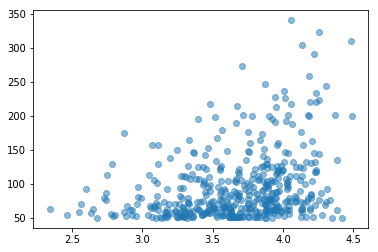

In [81]:
fix, ax = plt.subplots()

ax.scatter(movie_ratings[movie_ratings["count"] >= 50.0]["mean"], 
           movie_ratings[movie_ratings["count"] >= 50.0]["count"], alpha = 0.50)

plt.show()

**Exercise:** Rather than grouping by movie, you could group by the rater... are there some raters that are systematically negative, systematically positive? Even more interesting question, note that there is a time dimension, so maybe there is a time effect or life cycle component? 